>## Introduzione
>Il progetto scelto di Data Mining si concentra sul dataset "Primo Anno Coorti 2010-2016 per il CdS Informatica della Scuola di SMFN".<br>
Nel progetto verrano impiegate e discusse le tecniche di data mining viste a lezione quali **cluster analysis, association analysis e decision tree.**<br>


>## Pre processing
>Prima di usare le tecniche di data mining abbiamo trattato il dataset con una fase di pre processing in Python.
Per prima cosa abbiamo importato le librerie necessarie allo sviluppo del progetto e aperto il dataset.

In [1]:
import warnings
warnings.simplefilter("ignore")

In [2]:
import pandas as pd # gestione dataset
import matplotlib.pyplot as plt # plotting
import seaborn as sns # super-plotting
from path import Path # gestione dei path per l'import
from scipy import stats # calcolo della moda
import pandas_profiling # per un' analisi preliminare dei dati
from sklearn import preprocessing # per normalizzare o standardizzare i dati
from IPython.display import display
from sklearn.cluster import DBSCAN
%matplotlib inline

# variabili costanti per la gestione del path dei dati

PROJ_DIR = Path().getcwd().parent
DATA_DIR = PROJ_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
filename = RAW_DIR / "data_students_fixed.csv"
print(filename)

C:\Users\matte\dmo_progetto\data\raw\data_students_fixed.csv


In [3]:
# lettura dataset e informazioni sulle tabelle
data = pd.read_csv(filename)
data.head(500)

,Coorte,Genere,Voto_test,Crediti_totali,Crediti_convoto,Voto_medio,Scuola_provenienza,ASD,data_ASD,ARC,data_ARC,PRG,data_PRG,AN1,data_AN1,MDL,data_MDL,ING,data_ING
0,2010,M,18.00,3,NaN,0.0,TC,0,0,0,0,0,0,0,0,0,0,0,0000-00-00
1,2010,M,13.00,3,NaN,0.0,LS,0,0,0,0,0,0,0,0,0,0,0,0000-00-00
2,2010,M,15.00,3,NaN,0.0,IT,0,0,0,0,0,0,0,0,0,0,0,2011-02-22
3,2010,M,17.00,9,9.0,20.0,LS,25,2012-01-18,23,2014-07-24,26,2013-01-16,24,2012-07-06,20,2011-07-26,0,2014-09-23
4,2010,M,0.00,12,NaN,0.0,IT,0,0,0,0,0,0000-00-00,0,0,0,0,0,0
5,2010,F,12.00,12,NaN,0.0,LS,0,0,0,0,0,0,0,0000-00-00,0,0,0,0
6,2010,M,12.00,12,12.0,18.0,IT,18,2011-07-26,20,2016-02-12,18,2012-07-25,25,2012-07-06,0,0,0,0
7,2010,M,13.00,12,12.0,22.0,TC,22,2011-06-15,24,2014-01-28,21,2012-02-23,19,2013-07-18,24,2012-09-13,0,2013-09-26
8,2010,M,10.00,12,12.0,24.0,IP,24,2011-09-21,0,0,0,0,20,2013-09-19,18,2013-09-10,0,2014-03-05
9,2010,M,15.00,12,12.0,26.0,TC,26,2011-07-26,0,0,25,2012-02-23,0,0,0,0,0,0


In [4]:
data.dtypes

Coorte                  int64
Genere                 object
Voto_test             float64
Crediti_totali          int64
Crediti_convoto       float64
Voto_medio            float64
Scuola_provenienza     object
ASD                     int64
data_ASD               object
ARC                     int64
data_ARC               object
PRG                     int64
data_PRG               object
AN1                     int64
data_AN1               object
MDL                     int64
data_MDL               object
ING                     int64
data_ING               object
dtype: object

In [5]:
crit = list(True if x and y else False for x, y in zip( (data["MDL"] > 0).values, (data["data_MDL"] == "0000-00-00").values ) )

In [6]:
data[crit]

,Coorte,Genere,Voto_test,Crediti_totali,Crediti_convoto,Voto_medio,Scuola_provenienza,ASD,data_ASD,ARC,data_ARC,PRG,data_PRG,AN1,data_AN1,MDL,data_MDL,ING,data_ING


>Da un primo sguardo al data set e alla tabella dei tipi delle colonne, abbiamo notato una serie di inconsistenze come nella colonna **Crediti_convoto** è presente varie volte il valore NaN oppure non corrisponde il numero, ad alcuni studenti il voto medio non rispecchia il voto ottenuto negli esami, nelle colonne che rappresentano le date di registrazione degli esami per gli studenti compare la data **0000-00-00** ma anche il valore **0**.<br>
I nostri sforzi iniziali si sono quindi concentrati sul risolvere queste inconsistenze, abbiamo iniziato con le date.
La data **0000-00-00** può avere due origini distinte:
* l'esame è stato sostenuto dallo studente ma la data non è stata riportata
* l'esame non è stato sostenuto dallo studente e quindi tale valore rappresenta il valore NaN.<br>



>Queste ipotesi valgono anche per **0**, quindi siamo giunti alla conclusioni che i due valori svolgono la stessa funzione e che ne basta uno.<br>
Per risolvere questo problema abbiamo estratto una sottotabella con le colonne che riportano le date che chiamiamo **df_date** e poniamo a zero tutti gli elementi che hanno la data **0000-00-00**, dopodiché uniamo la tabella **df_date** e **data** con il metodo join di pandas.<br>

In [7]:
date_null = '0000-00-00'
df_date = data.filter(regex="data_") #estrai una sotto tabella che rappresenta le date degli esami dal dataset 
df_date_rows, df_date_cols = df_date.shape
for i in range(df_date_rows):
    for j in range(df_date_cols):
        if (df_date.iloc[i, j] == date_null):
            df_date.iloc[i, j] = '0'


In [8]:
date_cols_name = df_date.columns.tolist()
data = data.drop(date_cols_name, axis=1)
data = data.join(df_date) 

In [9]:
data.head(10).T

,0,1,2,3,4,5,6,7,8,9
Coorte,2010,2010,2010,2010,2010,2010,2010,2010,2010,2010
Genere,M,M,M,M,M,F,M,M,M,M
Voto_test,18,13,15,17,0,12,12,13,10,15
Crediti_totali,3,3,3,9,12,12,12,12,12,12
Crediti_convoto,NaN,NaN,NaN,9,NaN,NaN,12,12,12,12
Voto_medio,0,0,0,20,0,0,18,22,24,26
Scuola_provenienza,TC,LS,IT,LS,IT,LS,IT,TC,IP,TC
ASD,0,0,0,25,0,0,18,22,24,26
ARC,0,0,0,23,0,0,20,24,0,0
PRG,0,0,0,26,0,0,18,21,0,25


>Dalla visualizzazione degli istogrammi per le variabili di tipo numerico che compongono il datase, abbiamo osservato che la variabile **ING** ha solo il valore 0, pertanto abbiamo deciso di eliminarla.<br>Per individuare quali studenti hanno sostenuto l'esame di inglese è sufficiente la data di verbalizzazione.<br>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E8FED00DD8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001E88396C748>]], dtype=object)

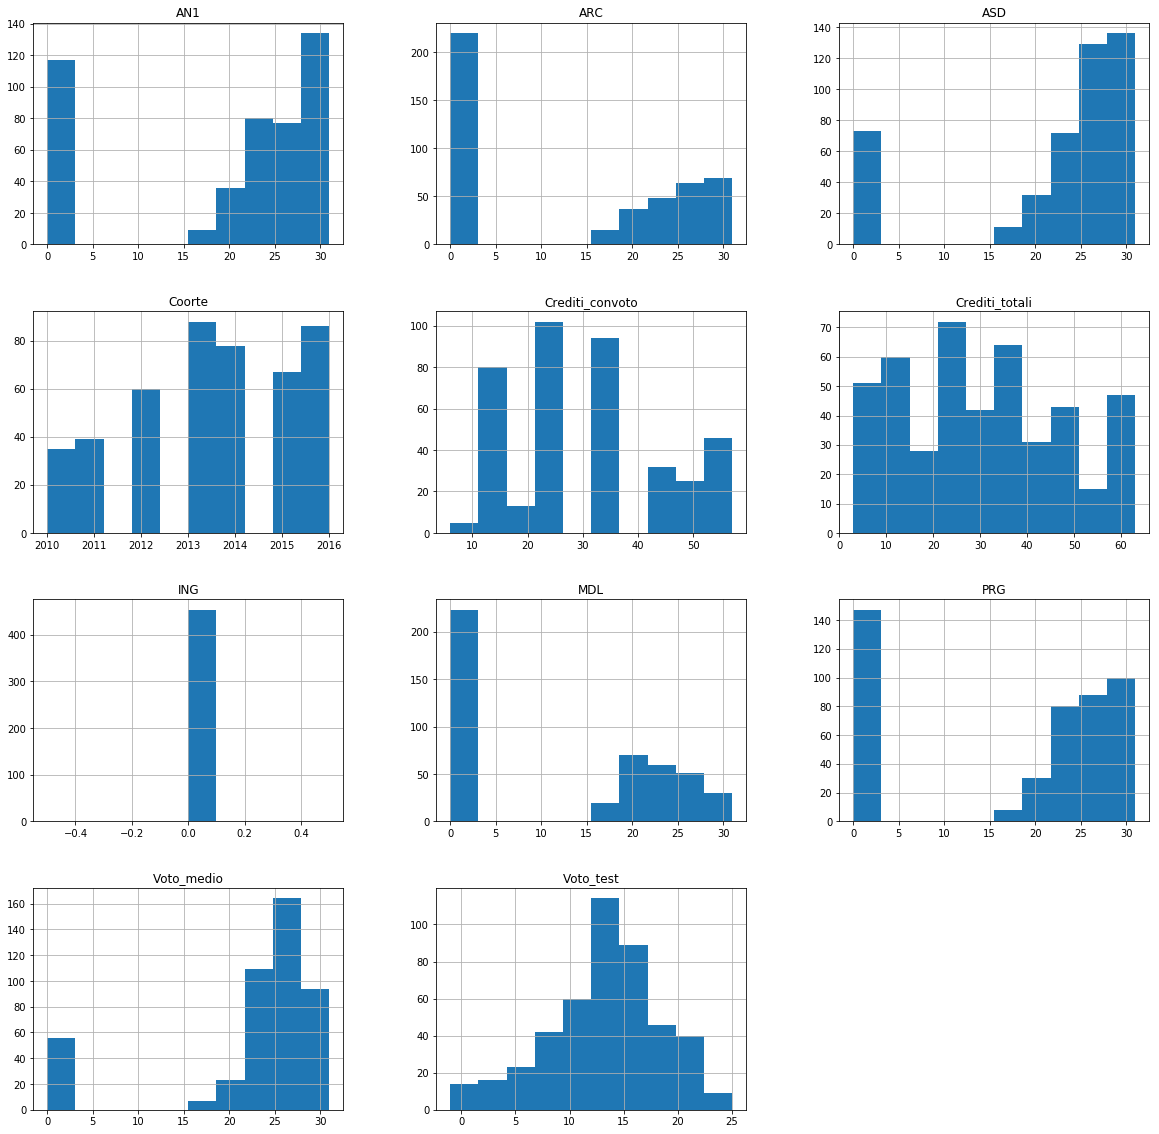

In [10]:
data.hist(figsize=(20,20))

In [11]:
#pd.DataFrame(data["ASD"]).boxplot(figsize=(30,30))
#sns.boxplot(x=data["ASD"])

In [12]:
data = data.drop("ING",axis=1)
data.head()

,Coorte,Genere,Voto_test,Crediti_totali,Crediti_convoto,Voto_medio,Scuola_provenienza,ASD,ARC,PRG,AN1,MDL,data_ASD,data_ARC,data_PRG,data_AN1,data_MDL,data_ING
0,2010,M,18.0,3,NaN,0.0,TC,0,0,0,0,0,0,0,0,0,0,0
1,2010,M,13.0,3,NaN,0.0,LS,0,0,0,0,0,0,0,0,0,0,0
2,2010,M,15.0,3,NaN,0.0,IT,0,0,0,0,0,0,0,0,0,0,2011-02-22
3,2010,M,17.0,9,9.0,20.0,LS,25,23,26,24,20,2012-01-18,2014-07-24,2013-01-16,2012-07-06,2011-07-26,2014-09-23
4,2010,M,0.0,12,NaN,0.0,IT,0,0,0,0,0,0,0,0,0,0,0


In [13]:
data.corr()

,Coorte,Voto_test,Crediti_totali,Crediti_convoto,Voto_medio,ASD,ARC,PRG,AN1,MDL
Coorte,1.000000,-0.341025,-0.022965,-0.041046,0.061705,0.027483,-0.212488,-0.135111,0.014798,-0.166378
Voto_test,-0.341025,1.000000,0.397075,0.366848,0.267535,0.245410,0.359815,0.349347,0.329787,0.358310
Crediti_totali,-0.022965,0.397075,1.000000,0.986651,0.633769,0.641025,0.632214,0.617689,0.650795,0.655800
Crediti_convoto,-0.041046,0.366848,0.986651,1.000000,0.435627,0.472342,0.580231,0.522421,0.532890,0.600332
Voto_medio,0.061705,0.267535,0.633769,0.435627,1.000000,0.781643,0.426462,0.543285,0.619112,0.429126
ASD,0.027483,0.245410,0.641025,0.472342,0.781643,1.000000,0.552360,0.604092,0.520789,0.483626
ARC,-0.212488,0.359815,0.632214,0.580231,0.426462,0.552360,1.000000,0.600641,0.568523,0.664489
PRG,-0.135111,0.349347,0.617689,0.522421,0.543285,0.604092,0.600641,1.000000,0.486039,0.542438
AN1,0.014798,0.329787,0.650795,0.532890,0.619112,0.520789,0.568523,0.486039,1.000000,0.567920
MDL,-0.166378,0.358310,0.655800,0.600332,0.429126,0.483626,0.664489,0.542438,0.567920,1.000000


In [14]:
data["PRG"].mean()

17.370860927152318

Abbiamo contrallato le colonne dei voti per vedere se ci sono degli studenti che hanno verbalizzato un esame con un voto inferiore a 18.

In [15]:
def checkVoti(name = ""):
    """
    checkVoti prende come parametro 'name' di tipo stringa che rappresenta il nome della variabile che rappresenta
    un corso di laurea del dataset e stampa quanti valori non sono ammissibili, ovvero compresi fra 1 e 17 compresi.
    """
    crit = (data[name] > 0) & (data[name] < 18)
    print("Valori dei voti relativi a {} compresi in [1, 17]: ".format(name), data[name][crit].shape[0])

In [16]:
exam_list = ["ASD", "ARC", "PRG", "AN1", "MDL"]
for voto in exam_list:
    checkVoti(voto)

Valori dei voti relativi a ASD compresi in [1, 17]:  0
Valori dei voti relativi a ARC compresi in [1, 17]:  0
Valori dei voti relativi a PRG compresi in [1, 17]:  0
Valori dei voti relativi a AN1 compresi in [1, 17]:  0
Valori dei voti relativi a MDL compresi in [1, 17]:  0


Il **numero di crediti con voto** e il **voto medio degli studenti** non sempre rispechia la loro carriera universitaria, a volte mancano questi valori oppure sono errati, quindi li abbiamo ricalcolati.

In [17]:
"""
estrazione del sotto dataset contenente i voti dei corsi
più le colonne voto_medio e crediti con voto
"""
career_list = ["Voto_medio","Crediti_convoto"]
data_mark = data[exam_list+career_list]
shape = data_mark.shape
data_mark




,ASD,ARC,PRG,AN1,MDL,Voto_medio,Crediti_convoto
0,0,0,0,0,0,0.0,NaN
1,0,0,0,0,0,0.0,NaN
2,0,0,0,0,0,0.0,NaN
3,25,23,26,24,20,20.0,9.0
4,0,0,0,0,0,0.0,NaN
5,0,0,0,0,0,0.0,NaN
6,18,20,18,25,0,18.0,12.0
7,22,24,21,19,24,22.0,12.0
8,24,0,0,20,18,24.0,12.0
9,26,0,25,0,0,26.0,12.0


In [18]:
"""
calcolo della media pesata per voto medio e dei crediti totali
"""
weights = [12,12,12,12,9]
for i in range(0,shape[0]):
    w_marks = 0
    tot_credit = 0
    for j in range(0,shape[1]-2):
        if(data_mark.iloc[i,j]!=0):
            w_marks += data_mark.iloc[i,j]*weights[j] #per il resto del carlino
            tot_credit += weights[j]
    
    data_mark.iloc[i,6] = tot_credit
    if(tot_credit>0):
        data_mark.iloc[i,5] = w_marks/tot_credit
    else:
        data_mark.iloc[i,5] = 0
                
                
           

In [19]:
data = data.drop(career_list, axis=1)
data_mark = data_mark.drop(exam_list, axis =1)
data = data.join(data_mark)

In [20]:
data.head().T

,0,1,2,3,4
Coorte,2010,2010,2010,2010,2010
Genere,M,M,M,M,M
Voto_test,18,13,15,17,0
Crediti_totali,3,3,3,9,12
Scuola_provenienza,TC,LS,IT,LS,IT
ASD,0,0,0,25,0
ARC,0,0,0,23,0
PRG,0,0,0,26,0
AN1,0,0,0,24,0
MDL,0,0,0,20,0


>Nell'istogramma non compaiono delle informazioni sulle variabili di tipo stringa, per questo abbiamo usato i metodi describe, value_counts e isnull per ricavarle.<br>
Abbiamo osservato la presenza di 12 valori Nan, pertanto abbiamo deciso di rimpiazzare tali valori con la **moda** che è rappresentata dal valore IT.<br>
Abbiamo deciso di utilizzare la moda perchè i valori di **Scuola_provenienza** non sono ordinabili e quindi la mediana non si poteva utilizzare.
Abbiamo fatto lo stesso per la variabile **Genere**, l'unica osservazione interessante e che la maggior parte degli studenti di Informatica è di genere maschile, la scoperta dell'acqua calda. 


In [21]:
print(data["Scuola_provenienza"].describe())
print(data["Scuola_provenienza"].value_counts())
print("Numero di valori Nan:", pd.isnull(data["Scuola_provenienza"]).sum())
data["Scuola_provenienza"] = data["Scuola_provenienza"].fillna("IT")
print("-------trattamento_con_la_moda--------")
print(data["Scuola_provenienza"].describe())
print(data["Scuola_provenienza"].value_counts())
print("Numero di valori Nan:", pd.isnull(data["Scuola_provenienza"]).sum())



count     441
unique     10
top        IT
freq      179
Name: Scuola_provenienza, dtype: object
IT     179
LS     144
TC      46
XX      24
AL      15
LC      11
IP      10
LL       8
IA       3
IPC      1
Name: Scuola_provenienza, dtype: int64
Numero di valori Nan: 12
-------trattamento_con_la_moda--------
count     453
unique     10
top        IT
freq      191
Name: Scuola_provenienza, dtype: object
IT     191
LS     144
TC      46
XX      24
AL      15
LC      11
IP      10
LL       8
IA       3
IPC      1
Name: Scuola_provenienza, dtype: int64
Numero di valori Nan: 0


In [22]:
print(data["Genere"].describe())
print(data["Genere"].value_counts())
print("Numero di valori Nan:", pd.isnull(data["Genere"]).sum())

count     453
unique      2
top         M
freq      385
Name: Genere, dtype: object
M    385
F     68
Name: Genere, dtype: int64
Numero di valori Nan: 0


>Le variabili **Genere** e **Scuola_provenienza** cosi però non possono essere usate dagli algoritmi di Data Mining e Machine Learning perchè questi sono stati ideati per lavorare con valori di tipo numerico e non categorico, per questo operiamo una codifica **hot-one** sulle due variabili attraverso pandas, cat.codes ha associato 1 per M e 0 per le F.<br>
Facciamo lo stesso per la variabile **Scuola_provenienza**, la codifica ha associato ai valori della variabile i seguenti numeri:<br>
* 4    IT
* 7    LS
* 8    TC
* 9    XX
* 0    AL
* 5    LC
* 2    IP
* 6    LL
* 1    IA
* 3    IPC

In [23]:
data["Genere"] = data["Genere"].astype('category')
data["Genere"] = data["Genere"].cat.codes
print(data["Genere"].describe())
print(data["Genere"].value_counts())

count    453.000000
mean       0.849890
std        0.357574
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: Genere, dtype: float64
1    385
0     68
Name: Genere, dtype: int64


In [24]:
data["Scuola_provenienza"] = data["Scuola_provenienza"].astype('category')
data["Scuola_provenienza"] = data["Scuola_provenienza"].cat.codes
print(data["Scuola_provenienza"].describe())
print(data["Scuola_provenienza"].value_counts())

count    453.000000
mean       5.485651
std        2.094640
min        0.000000
25%        4.000000
50%        5.000000
75%        7.000000
max        9.000000
Name: Scuola_provenienza, dtype: float64
4    191
7    144
8     46
9     24
0     15
5     11
2     10
6      8
1      3
3      1
Name: Scuola_provenienza, dtype: int64


In [25]:
print(data["Coorte"].describe())
print(data["Coorte"].value_counts())
print("Numero di valori Nan:", pd.isnull(data["Coorte"]).sum())

count     453.000000
mean     2013.501104
std         1.844179
min      2010.000000
25%      2012.000000
50%      2014.000000
75%      2015.000000
max      2016.000000
Name: Coorte, dtype: float64
2013    88
2016    86
2014    78
2015    67
2012    60
2011    39
2010    35
Name: Coorte, dtype: int64
Numero di valori Nan: 0


>Codifichiamo anche la variabile  coorte con la seguente:
    * 2013    3
    * 2016    6
    * 2014    4
    * 2015    5
    * 2012    2
    * 2011    1
    * 2010    0

In [26]:
data["Coorte"] = data["Coorte"].astype('category')
data["Coorte"] = data["Coorte"].cat.codes
print(data["Coorte"].describe())
print(data["Coorte"].value_counts())

count    453.000000
mean       3.501104
std        1.844179
min        0.000000
25%        2.000000
50%        4.000000
75%        5.000000
max        6.000000
Name: Coorte, dtype: float64
3    88
6    86
4    78
5    67
2    60
1    39
0    35
Name: Coorte, dtype: int64


>Sempre per quanto riguarda l'uso degli algoritmi, adesso standardizziamo (normalizziamo) tutte le variabili di tipo numerico del dataset attraverso l'uso del modulo **preprocessing** di **Skickit-learn**.<br>

In [27]:
#data["Voto_test"] = pd.Series(preprocessing.scale(data["Voto_test"]))
data.head(10).T

,0,1,2,3,4,5,6,7,8,9
Coorte,0,0,0,0,0,0,0,0,0,0
Genere,1,1,1,1,1,0,1,1,1,1
Voto_test,18,13,15,17,0,12,12,13,10,15
Crediti_totali,3,3,3,9,12,12,12,12,12,12
Scuola_provenienza,8,7,4,7,4,7,4,8,2,8
ASD,0,0,0,25,0,0,18,22,24,26
ARC,0,0,0,23,0,0,20,24,0,0
PRG,0,0,0,26,0,0,18,21,0,25
AN1,0,0,0,24,0,0,25,19,20,0
MDL,0,0,0,20,0,0,0,24,18,0


In [28]:
data.corr(method='pearson')

,Coorte,Genere,Voto_test,Crediti_totali,Scuola_provenienza,ASD,ARC,PRG,AN1,MDL,Voto_medio,Crediti_convoto
Coorte,1.000000,0.084127,-0.341025,-0.022965,-0.017321,0.027483,-0.212488,-0.135111,0.014798,-0.166378,0.087581,-0.143260
Genere,0.084127,1.000000,0.053847,0.036001,-0.200789,-0.009696,0.053682,0.200033,0.014661,0.003733,-0.022805,0.080041
Voto_test,-0.341025,0.053847,1.000000,0.397075,0.054645,0.245410,0.359815,0.349347,0.329787,0.358310,0.277146,0.379229
Crediti_totali,-0.022965,0.036001,0.397075,1.000000,0.041457,0.641025,0.632214,0.617689,0.650795,0.655800,0.591720,0.753572
Scuola_provenienza,-0.017321,-0.200789,0.054645,0.041457,1.000000,-0.032255,0.024174,-0.049025,0.075577,0.050168,-0.030979,0.008928
ASD,0.027483,-0.009696,0.245410,0.641025,-0.032255,1.000000,0.552360,0.604092,0.520789,0.483626,0.802001,0.769793
ARC,-0.212488,0.053682,0.359815,0.632214,0.024174,0.552360,1.000000,0.600641,0.568523,0.664489,0.443153,0.832728
PRG,-0.135111,0.200033,0.349347,0.617689,-0.049025,0.604092,0.600641,1.000000,0.486039,0.542438,0.570419,0.802056
AN1,0.014798,0.014661,0.329787,0.650795,0.075577,0.520789,0.568523,0.486039,1.000000,0.567920,0.644304,0.772502
MDL,-0.166378,0.003733,0.358310,0.655800,0.050168,0.483626,0.664489,0.542438,0.567920,1.000000,0.437199,0.769249


In [29]:
profile = pandas_profiling.ProfileReport(data)
profile.to_file(outputfile="output2.html")

# Suspance
Why Crediti_totali and Crediti_convoto have a correlation value by 0.753572	?
Ora non sono più fortemente correlate come all'inizio e lo riconferma il nuovo report con pandas profiling.

In [30]:
data.head(500)

,Coorte,Genere,Voto_test,Crediti_totali,Scuola_provenienza,ASD,ARC,PRG,AN1,MDL,data_ASD,data_ARC,data_PRG,data_AN1,data_MDL,data_ING,Voto_medio,Crediti_convoto
0,0,1,18.00,3,8,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0
1,0,1,13.00,3,7,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0
2,0,1,15.00,3,4,0,0,0,0,0,0,0,0,0,0,2011-02-22,0.000000,0.0
3,0,1,17.00,9,7,25,23,26,24,20,2012-01-18,2014-07-24,2013-01-16,2012-07-06,2011-07-26,2014-09-23,23.789474,57.0
4,0,1,0.00,12,4,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0
5,0,0,12.00,12,7,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0
6,0,1,12.00,12,4,18,20,18,25,0,2011-07-26,2016-02-12,2012-07-25,2012-07-06,0,0,20.250000,48.0
7,0,1,13.00,12,8,22,24,21,19,24,2011-06-15,2014-01-28,2012-02-23,2013-07-18,2012-09-13,2013-09-26,21.894737,57.0
8,0,1,10.00,12,2,24,0,0,20,18,2011-09-21,0,0,2013-09-19,2013-09-10,2014-03-05,20.909091,33.0
9,0,1,15.00,12,8,26,0,25,0,0,2011-07-26,0,2012-02-23,0,0,0,25.500000,24.0


In [31]:
mask = data["data_ING"].isin(['0'])
for i in range(0,len(mask)):
    if(mask.loc[i]==True):
        data.iloc[i,3] = 3+data.iloc[i,17]
    else:
        data.iloc[i,3] = data.iloc[i,17]

        

In [32]:
data.head(9).T

,0,1,2,3,4,5,6,7,8
Coorte,0,0,0,0,0,0,0,0,0
Genere,1,1,1,1,1,0,1,1,1
Voto_test,18,13,15,17,0,12,12,13,10
Crediti_totali,3,3,0,57,3,3,51,57,33
Scuola_provenienza,8,7,4,7,4,7,4,8,2
ASD,0,0,0,25,0,0,18,22,24
ARC,0,0,0,23,0,0,20,24,0
PRG,0,0,0,26,0,0,18,21,0
AN1,0,0,0,24,0,0,25,19,20
MDL,0,0,0,20,0,0,0,24,18


In [33]:
profile = pandas_profiling.ProfileReport(data)
profile.to_file(outputfile="output2.html")
data.corr(method='pearson')

,Coorte,Genere,Voto_test,Crediti_totali,Scuola_provenienza,ASD,ARC,PRG,AN1,MDL,Voto_medio,Crediti_convoto
Coorte,1.000000,0.084127,-0.341025,-0.125322,-0.017321,0.027483,-0.212488,-0.135111,0.014798,-0.166378,0.087581,-0.143260
Genere,0.084127,1.000000,0.053847,0.082491,-0.200789,-0.009696,0.053682,0.200033,0.014661,0.003733,-0.022805,0.080041
Voto_test,-0.341025,0.053847,1.000000,0.373323,0.054645,0.245410,0.359815,0.349347,0.329787,0.358310,0.277146,0.379229
Crediti_totali,-0.125322,0.082491,0.373323,1.000000,0.003125,0.778515,0.820977,0.798862,0.776612,0.761056,0.714418,0.997543
Scuola_provenienza,-0.017321,-0.200789,0.054645,0.003125,1.000000,-0.032255,0.024174,-0.049025,0.075577,0.050168,-0.030979,0.008928
ASD,0.027483,-0.009696,0.245410,0.778515,-0.032255,1.000000,0.552360,0.604092,0.520789,0.483626,0.802001,0.769793
ARC,-0.212488,0.053682,0.359815,0.820977,0.024174,0.552360,1.000000,0.600641,0.568523,0.664489,0.443153,0.832728
PRG,-0.135111,0.200033,0.349347,0.798862,-0.049025,0.604092,0.600641,1.000000,0.486039,0.542438,0.570419,0.802056
AN1,0.014798,0.014661,0.329787,0.776612,0.075577,0.520789,0.568523,0.486039,1.000000,0.567920,0.644304,0.772502
MDL,-0.166378,0.003733,0.358310,0.761056,0.050168,0.483626,0.664489,0.542438,0.567920,1.000000,0.437199,0.769249


In [34]:
data.head(200)

,Coorte,Genere,Voto_test,Crediti_totali,Scuola_provenienza,ASD,ARC,PRG,AN1,MDL,data_ASD,data_ARC,data_PRG,data_AN1,data_MDL,data_ING,Voto_medio,Crediti_convoto
0,0,1,18.0,3.0,8,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0
1,0,1,13.0,3.0,7,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0
2,0,1,15.0,0.0,4,0,0,0,0,0,0,0,0,0,0,2011-02-22,0.000000,0.0
3,0,1,17.0,57.0,7,25,23,26,24,20,2012-01-18,2014-07-24,2013-01-16,2012-07-06,2011-07-26,2014-09-23,23.789474,57.0
4,0,1,0.0,3.0,4,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0
5,0,0,12.0,3.0,7,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0
6,0,1,12.0,51.0,4,18,20,18,25,0,2011-07-26,2016-02-12,2012-07-25,2012-07-06,0,0,20.250000,48.0
7,0,1,13.0,57.0,8,22,24,21,19,24,2011-06-15,2014-01-28,2012-02-23,2013-07-18,2012-09-13,2013-09-26,21.894737,57.0
8,0,1,10.0,33.0,2,24,0,0,20,18,2011-09-21,0,0,2013-09-19,2013-09-10,2014-03-05,20.909091,33.0
9,0,1,15.0,27.0,8,26,0,25,0,0,2011-07-26,0,2012-02-23,0,0,0,25.500000,24.0


In [35]:
data.corr(method='pearson')

,Coorte,Genere,Voto_test,Crediti_totali,Scuola_provenienza,ASD,ARC,PRG,AN1,MDL,Voto_medio,Crediti_convoto
Coorte,1.000000,0.084127,-0.341025,-0.125322,-0.017321,0.027483,-0.212488,-0.135111,0.014798,-0.166378,0.087581,-0.143260
Genere,0.084127,1.000000,0.053847,0.082491,-0.200789,-0.009696,0.053682,0.200033,0.014661,0.003733,-0.022805,0.080041
Voto_test,-0.341025,0.053847,1.000000,0.373323,0.054645,0.245410,0.359815,0.349347,0.329787,0.358310,0.277146,0.379229
Crediti_totali,-0.125322,0.082491,0.373323,1.000000,0.003125,0.778515,0.820977,0.798862,0.776612,0.761056,0.714418,0.997543
Scuola_provenienza,-0.017321,-0.200789,0.054645,0.003125,1.000000,-0.032255,0.024174,-0.049025,0.075577,0.050168,-0.030979,0.008928
ASD,0.027483,-0.009696,0.245410,0.778515,-0.032255,1.000000,0.552360,0.604092,0.520789,0.483626,0.802001,0.769793
ARC,-0.212488,0.053682,0.359815,0.820977,0.024174,0.552360,1.000000,0.600641,0.568523,0.664489,0.443153,0.832728
PRG,-0.135111,0.200033,0.349347,0.798862,-0.049025,0.604092,0.600641,1.000000,0.486039,0.542438,0.570419,0.802056
AN1,0.014798,0.014661,0.329787,0.776612,0.075577,0.520789,0.568523,0.486039,1.000000,0.567920,0.644304,0.772502
MDL,-0.166378,0.003733,0.358310,0.761056,0.050168,0.483626,0.664489,0.542438,0.567920,1.000000,0.437199,0.769249


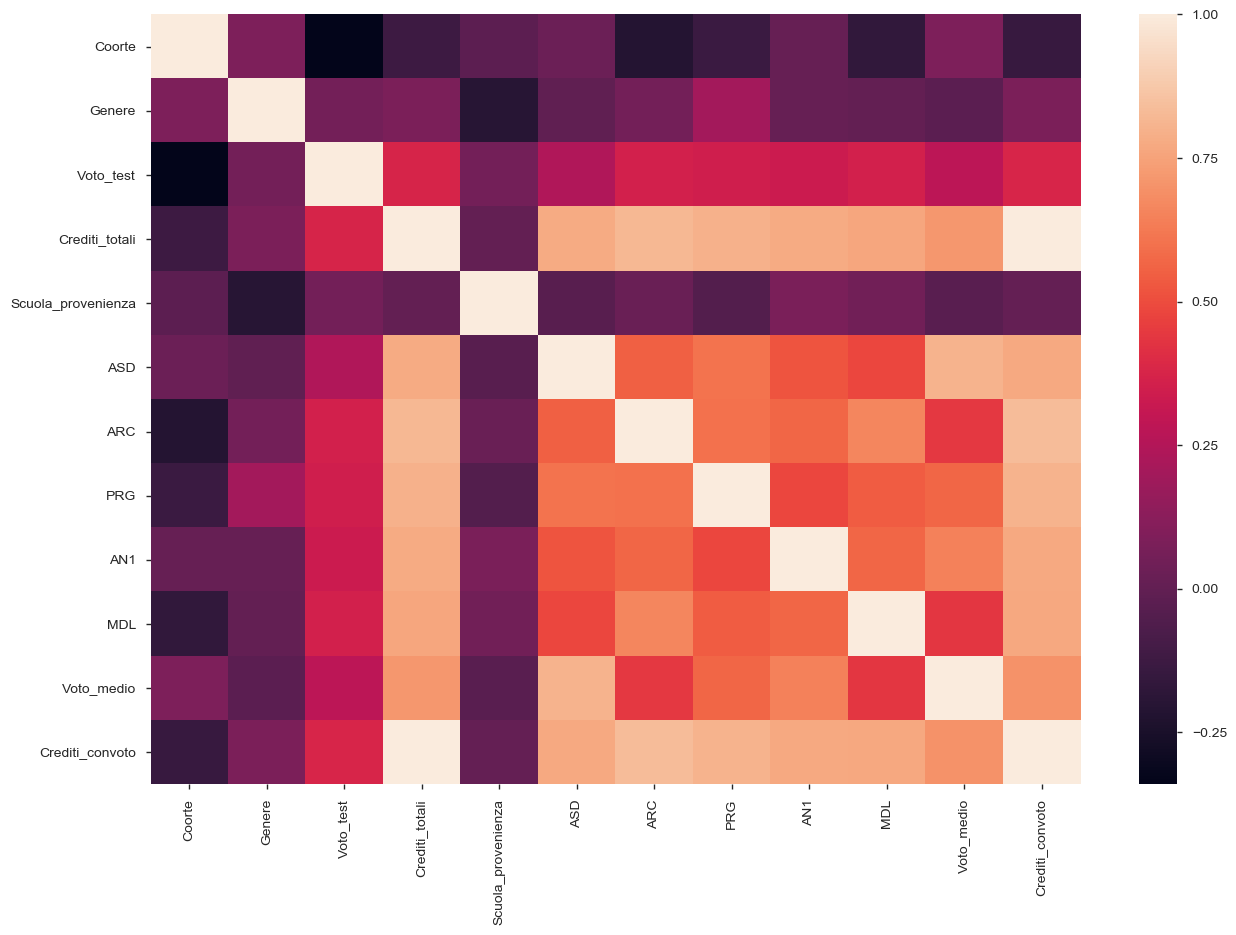

In [36]:
#visualizzazione della matrice di correlazione c
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr())

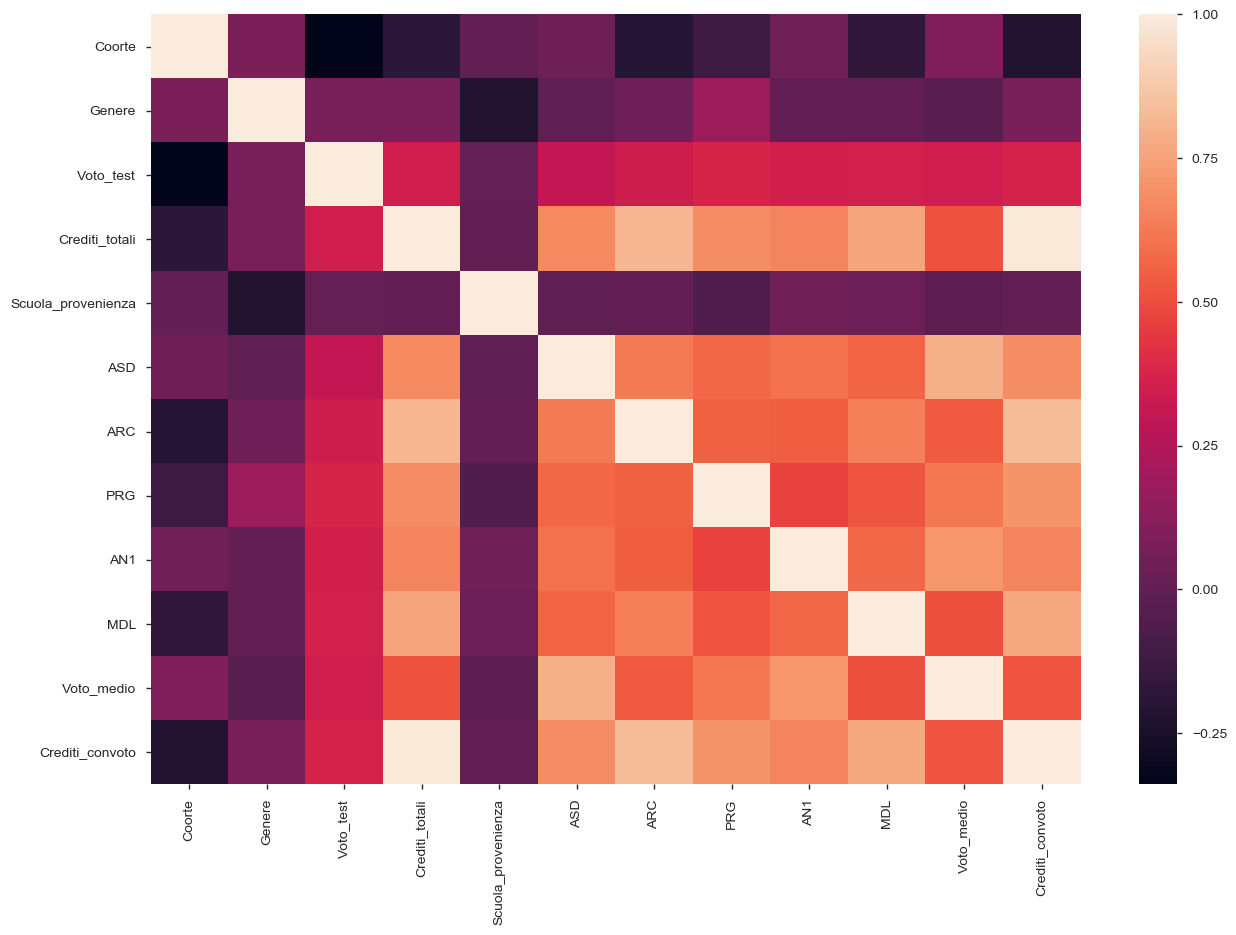

In [37]:
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(method='spearman'))

In [38]:
data

,Coorte,Genere,Voto_test,Crediti_totali,Scuola_provenienza,ASD,ARC,PRG,AN1,MDL,data_ASD,data_ARC,data_PRG,data_AN1,data_MDL,data_ING,Voto_medio,Crediti_convoto
0,0,1,18.00,3.0,8,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0
1,0,1,13.00,3.0,7,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0
2,0,1,15.00,0.0,4,0,0,0,0,0,0,0,0,0,0,2011-02-22,0.000000,0.0
3,0,1,17.00,57.0,7,25,23,26,24,20,2012-01-18,2014-07-24,2013-01-16,2012-07-06,2011-07-26,2014-09-23,23.789474,57.0
4,0,1,0.00,3.0,4,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0
5,0,0,12.00,3.0,7,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.0
6,0,1,12.00,51.0,4,18,20,18,25,0,2011-07-26,2016-02-12,2012-07-25,2012-07-06,0,0,20.250000,48.0
7,0,1,13.00,57.0,8,22,24,21,19,24,2011-06-15,2014-01-28,2012-02-23,2013-07-18,2012-09-13,2013-09-26,21.894737,57.0
8,0,1,10.00,33.0,2,24,0,0,20,18,2011-09-21,0,0,2013-09-19,2013-09-10,2014-03-05,20.909091,33.0
9,0,1,15.00,27.0,8,26,0,25,0,0,2011-07-26,0,2012-02-23,0,0,0,25.500000,24.0


In [39]:
data.dtypes

Coorte                   int8
Genere                   int8
Voto_test             float64
Crediti_totali        float64
Scuola_provenienza       int8
ASD                     int64
ARC                     int64
PRG                     int64
AN1                     int64
MDL                     int64
data_ASD               object
data_ARC               object
data_PRG               object
data_AN1               object
data_MDL               object
data_ING               object
Voto_medio            float64
Crediti_convoto       float64
dtype: object

In [40]:
column_list = ["Coorte","Genere", "Voto_test", "Crediti_totali","Scuola_provenienza", "ASD", "ARC", "PRG", "AN1","MDL","Voto_medio"]
data_nodate = data[column_list]
data_sc = preprocessing.StandardScaler()
data_stand = data_sc.fit_transform(data_nodate)
data_stand = pd.DataFrame(data_stand, columns=column_list)
data_stand.head(10).T

,0,1,2,3,4,5,6,7,8,9
Coorte,-1.900561,-1.900561,-1.900561,-1.900561,-1.900561,-1.900561,-1.900561,-1.900561,-1.900561,-1.900561
Genere,0.420266,0.420266,0.420266,0.420266,0.420266,-2.379446,0.420266,0.420266,0.420266,0.420266
Voto_test,0.930673,-0.027388,0.355836,0.739061,-2.518349,-0.219001,-0.219001,-0.027388,-0.602225,0.355836
Crediti_totali,-1.798459,-1.798459,-1.948940,0.910192,-1.798459,-1.798459,0.609231,0.910192,-0.293653,-0.594614
Scuola_provenienza,1.201700,0.723763,-0.710048,0.723763,-0.710048,0.723763,-0.710048,1.201700,-1.665921,1.201700
ASD,-2.167694,-2.167694,-2.167694,0.313520,-2.167694,-2.167694,-0.381220,0.015775,0.214272,0.412769
ARC,-1.005022,-1.005022,-1.005022,0.793248,-1.005022,-1.005022,0.558691,0.871434,-1.005022,-1.005022
PRG,-1.404790,-1.404790,-1.404790,0.697843,-1.404790,-1.404790,0.050879,0.293490,-1.404790,0.616972
AN1,-1.634948,-1.634948,-1.634948,0.397195,-1.634948,-1.634948,0.481868,-0.026168,0.058504,-1.634948
MDL,-0.993443,-0.993443,-0.993443,0.699353,-0.993443,-0.993443,-0.993443,1.037912,0.530073,-0.993443


In [41]:
data_stand.to_csv(path_or_buf="C:/Users/matte/dmo_progetto/data/interim/dataStand.csv")

In [42]:
data_stand.to_csv


<bound method DataFrame.to_csv of        Coorte    Genere  Voto_test  Crediti_totali  Scuola_provenienza  \
0   -1.900561  0.420266   0.930673       -1.798459            1.201700   
1   -1.900561  0.420266  -0.027388       -1.798459            0.723763   
2   -1.900561  0.420266   0.355836       -1.948940           -0.710048   
3   -1.900561  0.420266   0.739061        0.910192            0.723763   
4   -1.900561  0.420266  -2.518349       -1.798459           -0.710048   
5   -1.900561 -2.379446  -0.219001       -1.798459            0.723763   
6   -1.900561  0.420266  -0.219001        0.609231           -0.710048   
7   -1.900561  0.420266  -0.027388        0.910192            1.201700   
8   -1.900561  0.420266  -0.602225       -0.293653           -1.665921   
9   -1.900561  0.420266   0.355836       -0.594614            1.201700   
10  -1.900561 -2.379446   0.164224       -0.143173            1.201700   
11  -1.900561 -2.379446  -0.793838       -1.196537            0.723763   
12  

In [43]:
def frameApriori(ds,data_ING):
    exam_list = ds.columns
    ds_copy = ds.copy()
    shape = ds.shape
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            if(ds_copy.iloc[i,j]>0):
                ds_copy.iloc[i,j] ="yes"
            else:
                ds_copy.iloc[i,j] ="no"
                
    ing = []
    for i in range(0,len(data_ING)):
        if(data_ING[i]=="0"):
            ing.append("no")
        else:
            ing.append("yes")
    ds_copy["ING"] = ing
    
    return ds_copy
                
    

In [44]:
ds_apriori = frameApriori(data[exam_list], data["data_ING"])

ds_apriori.to_csv(path_or_buf="C:/Users/matte/dmo_progetto/data/interim/ds_apriori.csv")

In [45]:
data[exam_list].corr()

,ASD,ARC,PRG,AN1,MDL
ASD,1.000000,0.552360,0.604092,0.520789,0.483626
ARC,0.552360,1.000000,0.600641,0.568523,0.664489
PRG,0.604092,0.600641,1.000000,0.486039,0.542438
AN1,0.520789,0.568523,0.486039,1.000000,0.567920
MDL,0.483626,0.664489,0.542438,0.567920,1.000000
